# 2. Geopandas Basics

## Required Libraries and Tools

In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, MultiPoint, Polygon

## 2.1 Data structure

Basic geometric objects:  
- Points / Multi-Points  
- Lines / Multi-Lines  
- Polygons / Multi-Polygons  

A geometry is valid if:  
- Points are just a single location in space
- LineStrings are a series of points connected by straight, non-intersecting line segments
- Polygons must be simple, meaning their boundaries cannot self-intersect

### 2.1.1 GeoSeries

In [2]:
crs = 'EPSG:4326'                                #Define your desired crs
points = [Point(1, 1), Point(2, 2), Point(3, 3)] #Create a list of Point objects
s = gpd.GeoSeries(points, crs=crs)
s

0    POINT (1.00000 1.00000)
1    POINT (2.00000 2.00000)
2    POINT (3.00000 3.00000)
dtype: geometry

### 2.1.2 GeoDataFrame

#### Constructing GeoDataFrame from a dictionary

In [3]:
attr_name = ['a', 'b', 'c']                     #Create a list of attribute names
d = {'name': attr_name, 'geometry': points}
gdf = gpd.GeoDataFrame(d, crs=crs)
gdf

,name,geometry
0,a,POINT (1.00000 1.00000)
1,b,POINT (2.00000 2.00000)
2,c,POINT (3.00000 3.00000)


#### Constructing GeoDataFrame from a PandasDataFrame  
- PandasDF contains geometries in a form of wkt  
Note: Well-known text (WKT) is a text markup language for representing vector geometry objects  
ref: https://en.wikipedia.org/wiki/Well-known_text_representation_of_geometry

In [4]:
wkt_points = list(map(lambda point: point.wkt, points)) #Create a list of WKT representations of the points
d = {'name': attr_name, 'geometry': wkt_points}         
df = pd.DataFrame(d)
df

,name,geometry
0,a,POINT (1 1)
1,b,POINT (2 2)
2,c,POINT (3 3)


In [5]:
geometry = gpd.GeoSeries.from_wkt(df['geometry'])       #Convert WKT strings to geometric objects
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs=crs)  #Constructing GeoDF from a PandasDF
gdf

,name,geometry
0,a,POINT (1.00000 1.00000)
1,b,POINT (2.00000 2.00000)
2,c,POINT (3.00000 3.00000)


- PandasDF contains coornidates in separate columns 

In [6]:
d = {'name': ['a', 'b', 'c'], 'x': [1,2,3], 'y':[1,2,3]}
df = pd.DataFrame(d)
df

,name,x,y
0,a,1,1
1,b,2,2
2,c,3,3


In [7]:
geometry = gpd.points_from_xy(df['x'], df['y'])         #Create a GeoSeries of Point objects from the 'x' and 'y' columns                
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs=crs)
gdf

,name,x,y,geometry
0,a,1,1,POINT (1.00000 1.00000)
1,b,2,2,POINT (2.00000 2.00000)
2,c,3,3,POINT (3.00000 3.00000)


- GeoDF contains Multi-point geometry

In [8]:
m = {'name': ['multi'], 'geometry': MultiPoint([Point(0.25, 1), Point(0.5, 2), Point(0.75, 3)])}
gdf_multi = gpd.GeoDataFrame(m, crs=crs)
gdf_multi

,name,geometry
0,multi,"MULTIPOINT (0.25000 1.00000, 0.50000 2.00000, ..."


- Concatenate two GeoDFs

In [9]:
gdf_concat = pd.concat([gdf, gdf_multi], ignore_index=True)
gdf_concat

,name,x,y,geometry
0,a,1.0,1.0,POINT (1.00000 1.00000)
1,b,2.0,2.0,POINT (2.00000 2.00000)
2,c,3.0,3.0,POINT (3.00000 3.00000)
3,multi,NaN,NaN,"MULTIPOINT (0.25000 1.00000, 0.50000 2.00000, ..."


## 2.2 Basic methods and attributes

### Download World administrative boundaries data from
https://public.opendatasoft.com/explore/dataset/world-administrative-boundaries/export/?sort=iso3

In [10]:
# Adjust 'data_path' to the actual path where your data files are located
data_path = './data/'
gdf = gpd.read_file(data_path + 'asia-administrative-boundaries/cntry_3m.shp')

### 2.2.1 Attributes

#### geom_type: type of geometry

In [11]:
gdf['geometry'].geom_type.unique()

array(['Polygon'], dtype=object)

#### is_valid: tests if coordinates make a shape that is reasonable geometric shape

In [12]:
s = gpd.GeoSeries(
    [
        Polygon([(0, 0), (1, 1), (0, 1)]),
        Polygon([(0, 0), (1, 1), (0, 1)]),
        Polygon([(0, 0), (0, 2), (1, 1), (2, 2), (2, 0), (1, 1), (0, 0)]),  # bowtie geometry (its boundaries intersect itselfs)
        Polygon([(0, 0), (2, 2), (2, 0)]),
        None
    ]
)

In [13]:
geom_val = s.is_valid.sum()            #valid geometries
geom_inval = (~s.is_valid).sum()       #invalid geometries
print(f'Valid geometry {geom_val} \nInvalid geometry {geom_inval}')

Valid geometry 3 
Invalid geometry 2


#### total_bounds: tuple of max and min coordinates on each axis

In [14]:
gdf.total_bounds

array([ 7585247.18648638, -7314247.13658576, 19157028.51537167,
        7086219.3245197 ])

### 2.2.2 Methods

#### explode(): explode multi-part geometries into multiple single geometries

In [15]:
exploded = gdf_concat.explode(ignore_index=True)
exploded

,name,x,y,geometry
0,a,1.0,1.0,POINT (1.00000 1.00000)
1,b,2.0,2.0,POINT (2.00000 2.00000)
2,c,3.0,3.0,POINT (3.00000 3.00000)
3,multi,NaN,NaN,POINT (0.25000 1.00000)
4,multi,NaN,NaN,POINT (0.50000 2.00000)
5,multi,NaN,NaN,POINT (0.75000 3.00000)


#### make_valid(): fix invalid geometry

In [16]:
s.make_valid()

0    POLYGON ((0.00000 0.00000, 1.00000 1.00000, 0....
1    POLYGON ((0.00000 0.00000, 1.00000 1.00000, 0....
2    MULTIPOLYGON (((1.00000 1.00000, 0.00000 0.000...
3    POLYGON ((0.00000 0.00000, 2.00000 2.00000, 2....
4                                                 None
dtype: geometry

#### set_crs() and to_crs(): assign crs to gs/gdf and change crs of gd/gdf respectively

In [17]:
proj = '+proj=longlat +datum=WGS84 +no_defs +type=crs'
gdf.to_crs(crs=proj, inplace=True) #or
# gdf.to_crs(crs=crs, inplace=True)

#### to_file(): save file

In [18]:
out_path = 'path_to_your_output_folder/'
# gdf.to_file( out_path + 'file_name.shp', driver='ESRI Shapefile' )

#### plot()

<Axes: >

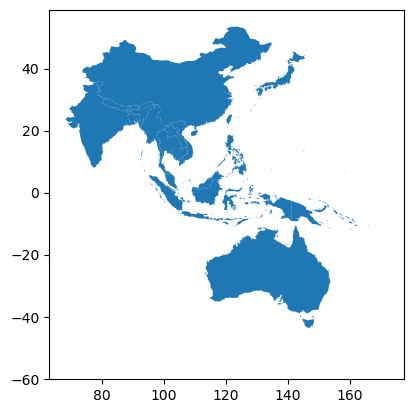

In [19]:
gdf.plot()

## 2.3 Clip data

### 2.3.1 Clipping by mask extent

In [20]:
# Define the coordinates for the bounding box to clip the data
# These coordinates must be in the same CRS as the original data
xmin, ymin, xmax, ymax = 95, 5, 110, 25
tha = gpd.clip(gdf, mask=(xmin, ymin, xmax, ymax))

<Axes: >

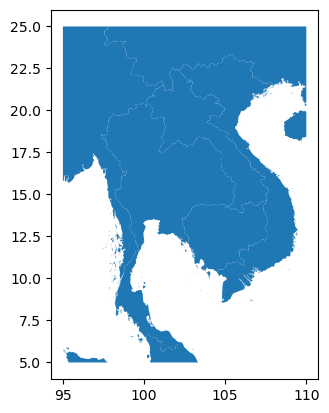

In [21]:
tha.plot()

### 2.3.2 Clipping by vector data (shapefile)

In [22]:
tha_shp = gpd.clip(gdf, mask=tha.total_bounds) #Get the bounding box info from the total_bounds attribute

<Axes: >

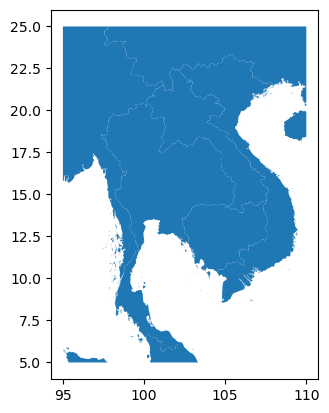

In [23]:
tha_shp.plot()

### 2.3.3 Clipping by raster data  
#### download Thailand population density data from:  
https://hub.worldpop.org/geodata/summary?id=44120

In [24]:
# Libraries for working with raster data
import xarray as xr
import rasterio

- Using Xarray

In [25]:
pop = xr.open_dataarray(data_path + 'tha_pd_2020_1km.tif')

In [26]:
pop['spatial_ref'] # Check crs

<xarray.DataArray 'spatial_ref' ()>
[1 values with dtype=int64]
Coordinates:
    spatial_ref  int64 ...
Attributes:
    crs_wkt:                      GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["...
    semi_major_axis:              6378137.0
    semi_minor_axis:              6356752.314245179
    inverse_flattening:           298.257223563
    reference_ellipsoid_name:     WGS 84
    longitude_of_prime_meridian:  0.0
    prime_meridian_name:          Greenwich
    geographic_crs_name:          WGS 84
    horizontal_datum_name:        World Geodetic System 1984
    grid_mapping_name:            latitude_longitude
    spatial_ref:                  GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["...
    GeoTransform:                 97.34874962141672 0.0083333333 0.0 20.46625...

In [27]:
# Extract bounding box from the data
lat = pop.coords['y']; lon = pop.coords['x']
min_lon = float(lon.min()); max_lon = float(lon.max())
min_lat = float(lat.min()); max_lat = float(lat.max())

In [28]:
tha_xr = gpd.clip(gdf, mask=(min_lon, min_lat, max_lon, max_lat))

<Axes: >

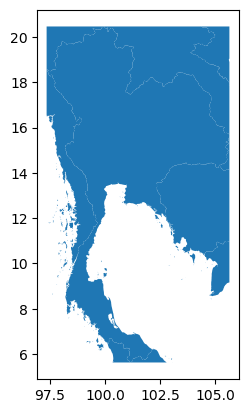

In [29]:
tha_xr.plot()

- Using Rasterio

In [30]:
pop = rasterio.open(data_path + 'tha_pd_2020_1km.tif')

In [31]:
tha3 = gpd.clip(gdf, mask=pop.bounds)    #Get the bounding box info from the bounds attribute

<Axes: >

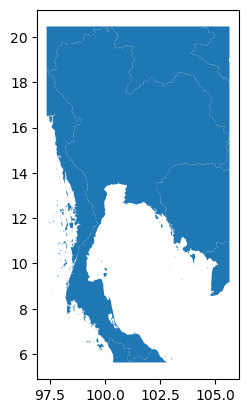

In [32]:
tha3.plot()